The Hull-White Short Rate Model is defined as:


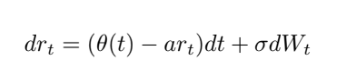

where a and σ are constants, and θ(t) is chosen in order to fit the input term structure of interest rates. Here we use QuantLib to show how to simulate the Hull-White model and investigate some of the properties. 

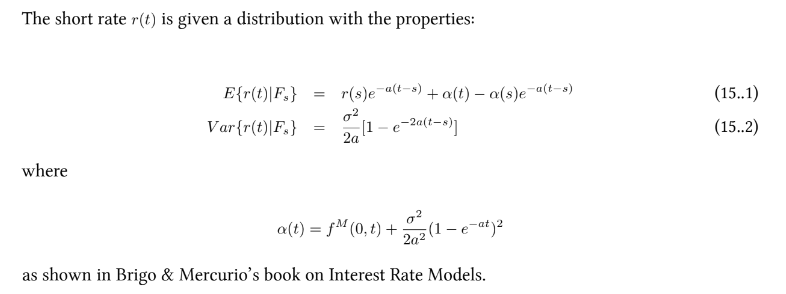

In [50]:
import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt 
from yield_curves.USD.us_tsy_yield_curve import USTsyYieldCurve

In [59]:
class HullWhiteModel:
    def __init__(self, yield_curve: ql.YieldTermStructureHandle, analysis_date: ql.Date,
                 time_step: int = 360, projection_tenor: int = 30, num_paths: int = 4096, params: list = [0.01, 0.02]) -> None:
        # Initial Setup
        self.as_of_date = analysis_date
        self.yield_curve = yield_curve
        ql.Settings.instance().evaluationDate = self.as_of_date

        # Hull White Model variables
        self.timestep = time_step
        self.length = projection_tenor # in years
        self.num_paths = num_paths
        self.sigma = params[0]
        self.a = params[1]
        

        # Conventions
        self.day_count = ql.Thirty360(ql.Thirty360.BondBasis)

        # Default Calibration
        self._calibrate()

    def _calibrate(self):
        print("Calibrating Hull White Model")
        hw_process = ql.HullWhiteProcess(self.yield_curve, a=self.a, sigma=self.sigma)

        # Generate random numbers
        self.rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(self.timestep, ql.UniformRandomGenerator()))

        # Generate discretised random paths
        self.seq = ql.GaussianPathGenerator(hw_process, self.length, self.timestep, self.rng, False)
        print("Calibrated!")

    def set_params(self, a: float, sigma: float):
        self.a = a
        self.sigma = sigma

        # Recalibrate the model
        self._calibrate()
    
    # We define alpha as per above equations
    def get_alpha(self, time: float):
        # YF for 1-day (proxy for short rate)
        yf = self.day_count.yearFraction(self.as_of_date, self.as_of_date + ql.Period(str("1D")))
        forward = self.yield_curve.forwardRate(time, time + yf,
                                               ql.Compounded).rate()
        alpha = forward + 0.5* np.power(self.sigma/self.a*(1.0 - np.exp(-self.a*time)), 2)
        return alpha

    def generate_paths(self):
        arr = np.zeros((self.num_paths, self.timestep+1))
        for i in range(self.num_paths):
            sample_path = self.seq.next()
            path = sample_path.value()
            time = [path.time(j) for j in range(len(path))]
            value = [path[j] for j in range(len(path))]
            arr[i, :] = np.array(value)
        return np.array(time), arr

In [60]:
as_of_date = ql.Date(1, 5, 2024)
num_paths = 4096
time_step = 360
max_tenor = 30 # Years
yield_curve = USTsyYieldCurve(date=as_of_date).get_yield_curve_handle()
hw_model = HullWhiteModel(
    analysis_date=as_of_date,
    yield_curve=yield_curve,
    num_paths=num_paths,
    time_step=time_step,
    projection_tenor=max_tenor,
)

Fetched raw data from USDT website!
Created bond helpers for all tenors!
Successfully calibrated the yield curve!
Calibrating Hull White Model
Calibrated!


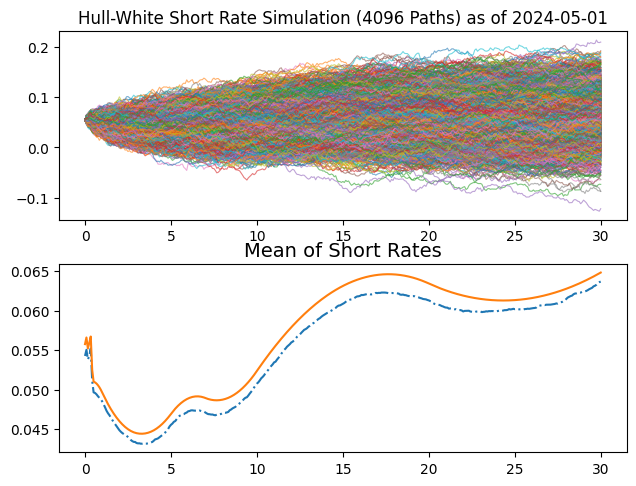

In [62]:
# Plotting the projected paths
time, paths = hw_model.generate_paths()
fig, axs = plt.subplots(2)
fig.tight_layout()

# Plot each path
for i in range(num_paths):
    axs[0].plot(time, paths[i, :], lw=0.8, alpha=0.6)

axs[0].set_title(f"Hull-White Short Rate Simulation ({num_paths} Paths) as of {as_of_date.ISO()}")

# Plotting mean of every path
avg = [np.mean(paths[:, i]) for i in range(time_step + 1)]
alphas = [hw_model.get_alpha(t) for t in time]
axs[1].plot(time, avg, "-.")
axs[1].plot(time, alphas, "-")
axs[1].set_title("Mean of Short Rates", size=14)

plt.show()
